In [1]:
import argparse
import random
import sys
import os
import yaml
from pyvirtualdisplay import Display
display1 = Display(visible=False, size=(400, 300))
display1.start()
from gym.wrappers import TimeLimit

from agent import NaiveAgent, FlorisAgent, SACAgent, TD3Agent
from wind_farm_gym import WindFarmEnv
from wind_farm_gym.wind_process import MVOUWindProcess


In [19]:
import progressbar
import time

In [21]:
for i in progressbar.progressbar(range(4,10)):
    # print(i)
    time.sleep(1)


100% (6 of 6) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06


In [16]:
progressbar.start()

AttributeError: module 'progressbar' has no attribute 'start'

In [11]:
# Read the configuration file
with open('./configs/miniature_wind_farm.yml') as stream:
# with open('./configs/NREL5MW_wind_farm.yml') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        sys.exit()

# Get a list of seeds from the config. If there are no seeds given, generate one instead
seeds = config.get('seed', random.randint(0, 2 ** 32 - 1))
seeds = list(seeds)



In [12]:
config['rescale_rewards']

True

In [13]:
seed = seeds[0]

# Read evaluation and training data from the config
eval_steps = config.get('eval_steps', 1000)        # Number of time steps in each evaluation
training_steps = config.get('train_steps', 10000)  # Number of time steps in training
n_eval_env = config.get('n_eval_env', 1)           # Number of evaluations
time_delta = config.get('time_delta', 1)           # Time difference between time steps, in seconds

# Set random seeds, one for training and n_eval_env seeds for evaluations
random.seed(seed)
data_generation_train_seed = random.randint(0, 2 ** 32 - 1)
data_generation_eval_seeds = [random.randint(0, 2 ** 32 - 1) for _ in range(n_eval_env)]

# Create a directory for the project results if needed
directory = os.path.join(config.get('directory', 'data'),
                         config.get('name', 'WindFarm'),
                         f'seed_{seed}')
if not os.path.exists(directory):
    os.makedirs(directory)

In [14]:
config.get('wind_process', {})
config.get('wind_process') is not None

False

In [15]:
# Generate the wind data and save it. If the data already exists, load previously generated data instead
print("Retrieving the wind data...")
if config.get('wind_process') is not None:
    print('wind_process is exist')
    # Check the directory
    data_path = os.path.join(directory, 'wind_data')
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    # Get the wind process data from the config
    wind_config = config.get('wind_process', {})

    # If the wind process is MVOU, read it
    if wind_config.get('type', None) == 'mvou':
        
        # Read the existing data
        eval_processes = [
            MVOUWindProcess.switch_to_csv(
                os.path.join(data_path, f'evaluation_data_{i}.csv'),
                time_steps=eval_steps,
                time_delta=time_delta,
                properties=wind_config.get('properties', None),
                seed=data_generation_eval_seeds[i]
            )
            for i in range(n_eval_env)
        ]
        train_process = MVOUWindProcess.switch_to_csv(
            os.path.join(data_path, 'training_data.csv'),
            time_steps=training_steps,
            time_delta=time_delta,
            properties=wind_config.get('properties', None),
            seed=data_generation_train_seed
        )
    elif wind_config.get('type', None) == 'uniform':
        # Uniform process, constant wind will be used from default_floris_input.json -> 7m/s, 270 degrees
        eval_processes, train_process = None, None
    
    else:
        # If you want to use a non-MVOU process, implement it here
        raise NotImplementedError
else:
    # wind  process is none, then find user wind data
    # Check the directory
    data_path = os.path.join('./configs/', 'wind_data')
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(data_path)
    wind_config = config.get('wind_process', {})
    eval_processes = [
            MVOUWindProcess.switch_to_csv(
                os.path.join(data_path, f'evaluation_data_uniform_{i}.csv'),
                time_steps=eval_steps,
                time_delta=time_delta,
                properties=wind_config.get('properties', None),
                seed=data_generation_eval_seeds[i]
            )
            for i in range(n_eval_env)
            ]
    train_process = MVOUWindProcess.switch_to_csv(
            os.path.join(data_path, 'training_data_uniform.csv'),
            time_steps=training_steps,
            time_delta=time_delta,
            properties=wind_config.get('properties', None),
            seed=data_generation_train_seed
        )
    # # In case there are no wind processes, constant wind will be used
    # eval_process, train_process = None, None

# Create the environments using the wind processes generated earlier
print("Setting  up the environments...")
env_config = config.get('environment', {})  # this is the non-wind data needed to setup the environment
# time_delta is stored separately in the config because it is needed by both the wind process and the env
env_config['time_delta'] = time_delta
train_env = TimeLimit(WindFarmEnv(wind_process=train_process, **env_config), training_steps)
if eval_processes is not None:
    eval_envs = [
        TimeLimit(WindFarmEnv(wind_process=eval_process, **env_config), eval_steps)
        for eval_process in eval_processes
    ]
else:
    eval_envs = TimeLimit(WindFarmEnv(wind_process=None, **env_config), eval_steps)

Retrieving the wind data...
./configs/wind_data
Setting  up the environments...


In [16]:
train_env.env.turbines[0].return_grid_points()

TypeError: return_grid_points() missing 1 required positional argument: 'coord'

In [17]:
0.2846646097215472*20

5.693292194430945

In [18]:
# Make a list of agents, check if their experiment data already exists, and  skip them if it does.
# If you want to rerun one of the agents in a previous experiment, delete their data from the results
# directory.
print("Making agent list...")
agents = config.get('agents', [])
results_directory = os.path.join(directory, 'results')

Making agent list...


In [19]:
# Check which agents were already run
for agent_description in agents:
    name = agent_description.get('name', agent_description.get('type', None))
    assert name is not None, 'agents must have a name and/or a type'
    agent_directory = os.path.join(results_directory, name)
    if os.path.exists(agent_directory):
        agent_description['exists'] = True

In [20]:
# Remove previously run agents from the list
agents = [agent for agent in agents if not agent.get('exists', False)]

In [21]:
run_config['rescale_rewards']

NameError: name 'run_config' is not defined

Creating agent TD3-wind...
Retrieving parameters for agent TD3-wind...
Initializing agent TD3-wind...


  0% (0 of 40000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

Running agent TD3-wind...


100% (40000 of 40000) |##################| Elapsed Time: 0:41:16 Time:  0:41:16


Done


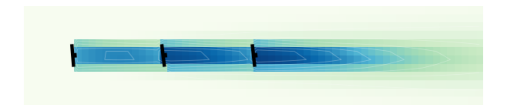

In [22]:
# Run the agents
for agent_description in agents:
    # Create a directory for  the agent
    name = agent_description.get('name', agent_description.get('type', None))
    agent_directory = os.path.join(results_directory, name)

    # Configure the experiment
    run_config = {
        'log_directory': agent_directory,                        # The directory to log
        'total_steps': training_steps,                           # Training steps
        'render': config.get('render', True),                   # Render the environment to the user?
        'rescale_rewards': config.get('rescale_rewards', True),  # Rescale the rewards to [0,1]?
        'reward_range': config.get('reward_range'),              # Reward range for rescaling
        'log': config.get('log', True),                          # Save logs?
        'log_every': config.get('log_every', 100),               # Save logs every log_every steps
        'eval_envs': eval_envs,                                  # A list of evaluation environments
        'eval_steps': eval_steps,                                # How many steps should an evaluation last
        'eval_every': config.get('eval_every', 100),             # Evaluate every eval_every steps
    }

    # Initialize an agent
    print(f'Creating agent {name}...')
    print(f'Retrieving parameters for agent {name}...')
    parameters = agent_description.get('parameters', {})
    # When agent's performance does not change over time, there is no need to re-evaluate it over and over.
    # FLORIS and Naive agents fall into this category, so we run their evaluations only once to speed things
    # up. If you want to, you can rerun them by changing the following variables.
    eval_once = False  # If true, evaluate agent once and copy the results every eval_every steps
    eval_only = False  # If true, don't run training, this agents needs evaluation only
    print(f'Initializing agent {name}...')
    if agent_description['type'] == 'naive':
        agent = NaiveAgent(name, train_env)
        eval_once = True
        eval_only = True
    elif agent_description['type'] == 'floris':
        agent = FlorisAgent(name, train_env, **parameters)
        eval_once = True
        eval_only = True
    elif agent_description['type'] == 'sac':
        agent = SACAgent(name, train_env, **parameters)
    elif agent_description['type'] == 'td3':
        agent = TD3Agent(name, train_env, **parameters)
    else:
        # Implement your custom agents here
        agent = None

    # Run the training and evaluations
    print(f'Running agent {name}...')
    if agent is not None:
        agent.run(eval_once=eval_once, eval_only=eval_only, **run_config)
        agent.close()

print('Done')

In [19]:
train_env.floris_interface.get_hor_plane(64, )

floris.tools.floris_interface.FlorisInterface INFO Default to hub height = 0.4 for horizontal plane.


In [11]:

def run(config, seed):
    """
    Run an experiment using a config file
    :param config: a config file with the parameters for agents, environment and wind data.
    :param seed: a random seed
    """
    # Read evaluation and training data from the config
    eval_steps = config.get('eval_steps', 1000)        # Number of time steps in each evaluation
    training_steps = config.get('train_steps', 10000)  # Number of time steps in training
    n_eval_env = config.get('n_eval_env', 1)           # Number of evaluations
    time_delta = config.get('time_delta', 1)           # Time difference between time steps, in seconds

    # Set random seeds, one for training and n_eval_env seeds for evaluations
    random.seed(seed)
    data_generation_train_seed = random.randint(0, 2 ** 32 - 1)
    data_generation_eval_seeds = [random.randint(0, 2 ** 32 - 1) for _ in range(n_eval_env)]

    # Create a directory for the project results if needed
    directory = os.path.join(config.get('directory', 'data'),
                             config.get('name', 'WindFarm'),
                             f'seed_{seed}')
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Generate the wind data and save it. If the data already exists, load previously generated data instead
    print("Retrieving the wind data...")
    if config.get('wind_process') is not None:
        # Check the directory
        data_path = os.path.join(directory, 'wind_data')
        if not os.path.exists(data_path):
            os.makedirs(data_path)

        # Get the wind process data from the config
        wind_config = config.get('wind_process', {})

        # If the wind process is MVOU, read it
        if wind_config.get('type', None) == 'mvou':
            # Read the existing data
            eval_processes = [
                MVOUWindProcess.switch_to_csv(
                    os.path.join(data_path, f'evaluation_data_{i}.csv'),
                    time_steps=eval_steps,
                    time_delta=time_delta,
                    properties=wind_config.get('properties', None),
                    seed=data_generation_eval_seeds[i]
                )
                for i in range(n_eval_env)
            ]
            train_process = MVOUWindProcess.switch_to_csv(
                os.path.join(data_path, 'training_data.csv'),
                time_steps=training_steps,
                time_delta=time_delta,
                properties=wind_config.get('properties', None),
                seed=data_generation_train_seed
            )
        else:
            # If you want to use a non-MVOU process, implement it here
            raise NotImplementedError
    else:
        # In case there are no wind processes, constant wind will be used
        eval_process, train_process = None, None

    # Create the environments using the wind processes generated earlier
    print("Setting  up the environments...")
    env_config = config.get('environment', {})  # this is the non-wind data needed to setup the environment
    # time_delta is stored separately in the config because it is needed by both the wind process and the env
    env_config['time_delta'] = time_delta
    train_env = TimeLimit(WindFarmEnv(wind_process=train_process, **env_config), training_steps)
    eval_envs = [
        TimeLimit(WindFarmEnv(wind_process=eval_process, **env_config), eval_steps)
        for eval_process in eval_processes
    ]

    # Make a list of agents, check if their experiment data already exists, and  skip them if it does.
    # If you want to rerun one of the agents in a previous experiment, delete their data from the results
    # directory.
    print("Making agent list...")
    agents = config.get('agents', [])
    results_directory = os.path.join(directory, 'results')

    # Check which agents were already run
    for agent_description in agents:
        name = agent_description.get('name', agent_description.get('type', None))
        assert name is not None, 'agents must have a name and/or a type'
        agent_directory = os.path.join(results_directory, name)
        if os.path.exists(agent_directory):
            agent_description['exists'] = True

    # Remove previously run agents from the list
    agents = [agent for agent in agents if not agent.get('exists', False)]

    # Run the agents
    for agent_description in agents:
        # Create a directory for  the agent
        name = agent_description.get('name', agent_description.get('type', None))
        agent_directory = os.path.join(results_directory, name)

        # Configure the experiment
        run_config = {
            'log_directory': agent_directory,                        # The directory to log
            'total_steps': training_steps,                           # Training steps
            'render': config.get('render', False),                   # Render the environment to the user?
            'rescale_rewards': config.get('rescale_rewards', True),  # Rescale the rewards to [0,1]?
            'reward_range': config.get('reward_range'),              # Reward range for rescaling
            'log': config.get('log', True),                          # Save logs?
            'log_every': config.get('log_every', 100),               # Save logs every log_every steps
            'eval_envs': eval_envs,                                  # A list of evaluation environments
            'eval_steps': eval_steps,                                # How many steps should an evaluation last
            'eval_every': config.get('eval_every', 100),             # Evaluate every eval_every steps
        }

        # Initialize an agent
        print(f'Creating agent {name}...')
        print(f'Retrieving parameters for agent {name}...')
        parameters = agent_description.get('parameters', {})
        # When agent's performance does not change over time, there is no need to re-evaluate it over and over.
        # FLORIS and Naive agents fall into this category, so we run their evaluations only once to speed things
        # up. If you want to, you can rerun them by changing the following variables.
        eval_once = False  # If true, evaluate agent once and copy the results every eval_every steps
        eval_only = False  # If true, don't run training, this agents needs evaluation only
        print(f'Initializing agent {name}...')
        if agent_description['type'] == 'naive':
            agent = NaiveAgent(name, train_env)
            eval_once = True
            eval_only = True
        elif agent_description['type'] == 'floris':
            agent = FlorisAgent(name, train_env, **parameters)
            eval_once = True
            eval_only = True
        elif agent_description['type'] == 'sac':
            agent = SACAgent(name, train_env, **parameters)
        elif agent_description['type'] == 'td3':
            agent = TD3Agent(name, train_env, **parameters)
        else:
            # Implement your custom agents here
            agent = None

        # Run the training and evaluations
        print(f'Running agent {name}...')
        if agent is not None:
            agent.run(eval_once=eval_once, eval_only=eval_only, **run_config)
            agent.close()

    print('Done')


In [10]:
# Run the experiments changing only the seeds
for seed in seeds:
    print(f'seed : {seed}')
    # run(config, seed)

seed : 3838619817
seed : 2608428279
seed : 240072600
seed : 553262114
seed : 2926908060
seed : 910166857
seed : 2211266602
seed : 1808337251
seed : 1446729330
seed : 905187325


In [9]:
run(config, 2608428279)

Retrieving the wind data...
Setting  up the environments...
Making agent list...
Creating agent TD3-wind...
Retrieving parameters for agent TD3-wind...
Initializing agent TD3-wind...


  0% (0 of 60480) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

Running agent TD3-wind...


  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:25 Time:  0:00:25
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (11 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:26


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (10 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:28


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (10 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:28


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (11 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:26


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (11 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:26


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:26


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (22 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:26


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (10 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:28


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


100% (2880 of 2880) |####################| Elapsed Time: 0:00:26 Time:  0:00:26
  0% (12 of 2880) |                      | Elapsed Time: 0:00:00 ETA:   0:00:25


Evaluating...


 57% (1651 of 2880) |###########         | Elapsed Time: 0:00:14 ETA:   0:00:11

KeyboardInterrupt: 